In [79]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import statsmodels.api as sm
from datetime import date, timedelta, time 


# Set Korean font for matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # To display minus sign correctly

df = pd.read_csv('./results/2nd-dataset_20230101~20241231_전국_전종목_전체요일_20250605_113550.csv')

# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

In [80]:
df.head(10)

,date,region,accident_count,injury_count,death_count,game_count,sports_type,temperature,precipitation,snow_depth,weather_condition,is_post_season,is_hometeam_win,is_holiday,weekday,audience,game_start_time,game_end_time
0,2023-01-01,강원 강릉시,5,10,0,0,없음,4.9,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
1,2023-01-01,강원 원주시,3,6,0,0,없음,0.0,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
2,2023-01-01,강원 춘천시,0,0,0,0,없음,-2.1,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
3,2023-01-01,경기 고양시,0,0,0,1,농구,-0.6,0.0,0.0,정보없음,0,0,1,일,0,0 days 14:00:00,0 days 15:20:00
4,2023-01-01,경기 김포시,0,0,0,0,없음,-0.2,0.0,0.0,정보없음,0,0,1,일,0,NaN,NaN
5,2023-01-01,경기 수원시,15,20,0,0,없음,-2.0,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
6,2023-01-01,경기 안산시,11,13,0,1,배구,-2.9,0.0,0.0,정보없음,0,1,1,일,1906,0 days 14:00:00,0 days 16:00:00
7,2023-01-01,경기 안양시,0,0,0,0,없음,1.1,0.0,0.0,정보없음,0,0,1,일,0,NaN,NaN
8,2023-01-01,경기 의정부시,1,1,0,0,없음,-1.5,0.0,0.0,정보없음,0,0,1,일,0,NaN,NaN
9,2023-01-01,경기 이천시,1,1,0,0,없음,-1.9,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN


In [81]:
df.columns

Index(['date', 'region', 'accident_count', 'injury_count', 'death_count',
       'game_count', 'sports_type', 'temperature', 'precipitation',
       'snow_depth', 'weather_condition', 'is_post_season', 'is_hometeam_win',
       'is_holiday', 'weekday', 'audience', 'game_start_time',
       'game_end_time'],
      dtype='object')

                      건수     비율
game_end_time      25202  88.4%
game_start_time    25202  88.4%
temperature          934   3.3%
precipitation        928   3.3%
snow_depth           928   3.3%
weather_condition    197   0.7%
game_count             0   0.0%
sports_type            0   0.0%
death_count            0   0.0%
injury_count           0   0.0%
region                 0   0.0%
is_post_season         0   0.0%
is_hometeam_win        0   0.0%
is_holiday             0   0.0%
weekday                0   0.0%
audience               0   0.0%
accident_count         0   0.0%
date                   0   0.0%


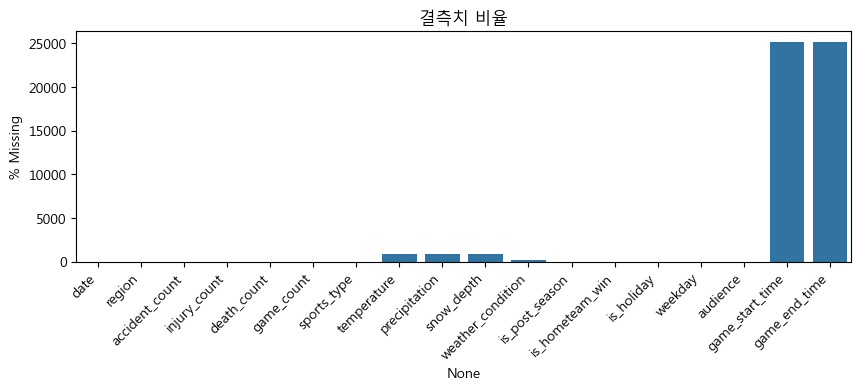

In [82]:
# 결측치 체크
na_cnt = df.isna().sum()
na_rate = (na_cnt/len(df)).map(pct)
na_report = pd.concat([na_cnt, na_rate], axis=1, keys=["건수", "비율"])
print(na_report.sort_values("비율", ascending=False))

# 결측치 시각화 ---------------
plt.figure(figsize=(10,3))
sns.barplot(x=na_cnt.index, y=na_cnt.values)
plt.xticks(rotation=45, ha="right"); plt.ylabel("% Missing")
plt.title("결측치 비율"); plt.show()

In [83]:
## 결측치 처리. 
## 다음 값들은 모두 0 으로 채움
## precipitatione, death_count, injury_count, accident_count, snow_depth     

# 결측치를 0으로 채울 대상 컬럼 목록
cols_to_fill = ["precipitation", "snow_depth", "temperature"]

# 실제 존재하는 컬럼만 선택해 NaN → 0 대체
df.loc[:, df.columns.intersection(cols_to_fill)] = (
    df.loc[:, df.columns.intersection(cols_to_fill)].fillna(0)
)

# 확인
print(df[cols_to_fill].isna().sum())

precipitation    0
snow_depth       0
temperature      0
dtype: int64


In [84]:
# audience 에 대한 결측치는 각 지역 관중수의 평균에 펴차를 두어 계산
# region별 평균값 계산

print(f"관중수가 0인 행 갯수:{(df['audience'] == 0).sum()}")
print(f"스포츠 종목이 없음 갯수:{(df['sports_type'] == '없음').sum()}")

region_mean = df.groupby('region')['audience'].mean()
print(region_mean)

def impute_with_noise(row):
    if row['sports_type'] != '없음' and row['audience'] == 0:
        mean_val = region_mean.get(row['region'], np.nan)
        if pd.notna(mean_val):
            noise = np.random.normal(loc=0, scale=0.1)  # 평균 0, 표준편차 0.1 → ±10% 정도 오차
            return (mean_val * (1 + noise)).astype(int)
    return row['audience']

# 4. 적용
df['audience'] = df.apply(impute_with_noise, axis=1)

관중수가 0인 행 갯수:26261
스포츠 종목이 없음 갯수:25202
region
강원 강릉시      275.989056
강원 원주시        0.000000
강원 춘천시      129.894665
경기 고양시        0.000000
경기 김포시        0.000000
경기 수원시     3081.552668
경기 안산시       91.166895
경기 안양시        0.000000
경기 의정부시      71.076607
경기 이천시        0.000000
경기 화성시      203.534884
경남 창원시     2030.247606
경북 구미시        0.000000
경북 김천시      215.436389
경북 포항시      562.377565
광주 광산구      252.166895
광주 북구      2827.045144
대구 동구       577.731874
대구 수성구     3281.521204
대전 유성구      590.250342
대전 중구       291.132695
부산 동래구     3182.582763
부산 연제구        0.000000
서울 구로구     2067.519836
서울 마포구     1273.761970
서울 송파구     7698.253078
서울 양천구        0.000000
서울 중구       290.322845
울산 남구      1066.809850
울산 중구         0.000000
인천 계양구       91.359781
인천 남동구      242.989056
인천 미추홀구    3186.839945
인천 서구       516.923393
전북 군산시        0.000000
전북 전주시      731.054720
제주 제주시      321.393981
충남 천안시      120.634747
충북 청주시       59.549932
Name: audience, dtype: float64


In [85]:
df['audience'] = df['audience'].astype(int)
df

,date,region,accident_count,injury_count,death_count,game_count,sports_type,temperature,precipitation,snow_depth,weather_condition,is_post_season,is_hometeam_win,is_holiday,weekday,audience,game_start_time,game_end_time
0,2023-01-01,강원 강릉시,5,10,0,0,없음,4.9,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
1,2023-01-01,강원 원주시,3,6,0,0,없음,0.0,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
2,2023-01-01,강원 춘천시,0,0,0,0,없음,-2.1,0.0,0.0,맑음,0,0,1,일,0,NaN,NaN
3,2023-01-01,경기 고양시,0,0,0,1,농구,-0.6,0.0,0.0,정보없음,0,0,1,일,0,0 days 14:00:00,0 days 15:20:00
4,2023-01-01,경기 김포시,0,0,0,0,없음,-0.2,0.0,0.0,정보없음,0,0,1,일,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28504,2024-12-31,전북 군산시,3,9,0,0,없음,3.1,0.0,0.0,맑음,0,0,0,화,0,NaN,NaN
28505,2024-12-31,전북 전주시,7,9,0,0,없음,3.5,0.1,0.1,비,0,0,0,화,0,NaN,NaN
28506,2024-12-31,제주 제주시,12,16,0,0,없음,8.6,0.0,0.0,약간흐림,0,0,0,화,0,NaN,NaN
28507,2024-12-31,충남 천안시,7,10,0,0,없음,1.7,0.0,0.0,맑음,0,0,0,화,0,NaN,NaN


In [86]:
print(f"관중수가 0인 행 갯수:{(df['audience'] == 0).sum()}")
print(f"스포츠 종목이 없음 갯수:{(df['sports_type'] == '없음').sum()}")

관중수가 0인 행 갯수:25455
스포츠 종목이 없음 갯수:25202


In [91]:
# 데이터 전처리
# 모든 스포츠 불린 컬럼 생성
all_sports = set()
for sports_list in df['sports_type'].unique():
    if sports_list != "없음":
        for sport in sports_list.split(','):
            all_sports.add(sport.strip()) # .strip() to remove potential leading/trailing spaces

print("\nIdentified unique sport types:", sorted(list(all_sports)))

# Create boolean columns for each identified sport
for sport in sorted(list(all_sports)):
    df[f'is_{sport}'] = df['sports_type'].apply(lambda x: sport in x)

# 모든 요일 불린 컬럼 생성
all_weekday = set()
for day_list in df['weekday'].unique():
    for day in day_list:
        all_weekday.add(day.strip()) # .strip() to remove potential leading/trailing spaces

print("\nIdentified unique day:", sorted(list(all_weekday)))

# Create boolean columns for each identified day
for day in sorted(list(all_weekday)):
    df[f'is_{day}'] = df['weekday'].apply(lambda x: day in x)
    
# 모든 날씨 더미 컬럼 생성
df = pd.get_dummies(df, columns=['weather_condition'])
df= df.drop('weather_condition_정보없음', axis=1)

# 사고 점수 가중치 부여    
df['accident_score'] = df['accident_count'] + 3 * df['injury_count']


Identified unique sport types: ['농구', '배구', '야구', '여자배구', '축구']

Identified unique day: ['금', '목', '수', '월', '일', '토', '화']


In [88]:
df['date'] = pd.to_datetime(df['date'])
df['game_start_time'] = df['game_start_time'].str.extract(r'(\d{2}:\d{2}:\d{2})')[0]
df['game_start_time'] = pd.to_datetime(df['game_start_time'], format='%H:%M:%S', errors='coerce').dt.time

df['game_end_time'] = df['game_end_time'].str.extract(r'(\d{2}:\d{2}:\d{2})')[0]
df['game_end_time'] = pd.to_datetime(df['game_end_time'], format='%H:%M:%S', errors='coerce').dt.time

In [92]:
# 독립 변수와 종속 변수 정의
X = df.drop(columns=["accident_score", "accident_count", "injury_count", "death_count", "region", "weekday", "sports_type", "sports_type"])
y = df['accident_score']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28509 entries, 0 to 28508
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    28509 non-null  datetime64[ns]
 1   game_count              28509 non-null  int64         
 2   temperature             28509 non-null  float64       
 3   precipitation           28509 non-null  float64       
 4   snow_depth              28509 non-null  float64       
 5   is_post_season          28509 non-null  int64         
 6   is_hometeam_win         28509 non-null  int64         
 7   is_holiday              28509 non-null  int64         
 8   audience                28509 non-null  int32         
 9   game_start_time         3307 non-null   object        
 10  game_end_time           3307 non-null   object        
 11  is_농구                   28509 non-null  bool          
 12  is_배구                   28509 non-null  bool  

In [93]:
df.columns

Index(['date', 'region', 'accident_count', 'injury_count', 'death_count',
       'game_count', 'sports_type', 'temperature', 'precipitation',
       'snow_depth', 'is_post_season', 'is_hometeam_win', 'is_holiday',
       'weekday', 'audience', 'game_start_time', 'game_end_time', 'is_농구',
       'is_배구', 'is_야구', 'is_여자배구', 'is_축구', 'is_금', 'is_목', 'is_수', 'is_월',
       'is_일', 'is_토', 'is_화', 'weather_condition_맑음', 'weather_condition_비',
       'weather_condition_약간흐림', 'weather_condition_흐림', 'accident_score'],
      dtype='object')

# 스포츠 종목 비교
## 야구 - 경기 있는 날

In [135]:
## 포이송 회기 변수 적용
# 포아송 회귀모델 정의 (GLM - Generalized Linear Model)
game_day_baseball = df[df['is_야구']]
no_game_day_baseball = df[~df['is_야구']]

formula = """accident_score ~ game_count + temperature + precipitation + snow_depth + is_post_season + is_hometeam_win + is_holiday + audience + 
        is_월 + is_화 + is_수 + is_목 + is_금 + is_토 + weather_condition_맑음 + weather_condition_비 + weather_condition_약간흐림 + weather_condition_흐림"""

formula2 = """accident_score ~ is_post_season + is_hometeam_win + audience + is_holiday + temperature + precipitation + snow_depth +
        weather_condition_맑음 + weather_condition_비 + weather_condition_약간흐림 + weather_condition_흐림"""

model = smf.glm(
    formula=formula2,
    data=game_day_baseball,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                 1810
Model:                            GLM   Df Residuals:                     1799
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24356.
Date:                    목, 05 6 2025   Deviance:                       41560.
Time:                        14:42:36   Pearson chi2:                 3.98e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4821
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## 야구 - 경기 없는 날

In [136]:
model = smf.glm(
    formula=formula2,
    data=no_game_day_baseball,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                26699
Model:                            GLM   Df Residuals:                    26688
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2156e+05
Date:                    목, 05 6 2025   Deviance:                   5.3605e+05
Time:                        14:42:50   Pearson chi2:                 5.54e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1441
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## 축구 - 경기 있는 날

In [137]:
game_day_soccer = df[df['is_축구']]
no_game_day_soccer = df[~df['is_축구']]

model = smf.glm(
    formula=formula2,
    data=game_day_soccer,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                  461
Model:                            GLM   Df Residuals:                      450
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5218.0
Date:                    목, 05 6 2025   Deviance:                       8241.0
Time:                        14:42:53   Pearson chi2:                 9.03e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2853
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## 축구 - 경기 없는 날

In [138]:
model = smf.glm(
    formula=formula2,
    data=no_game_day_soccer,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                28048
Model:                            GLM   Df Residuals:                    28037
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4058e+05
Date:                    목, 05 6 2025   Deviance:                   5.6914e+05
Time:                        14:42:57   Pearson chi2:                 5.84e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1700
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## 배구 - 경기 있는 날

In [139]:
game_day_volleyball = df[df['is_배구']]
no_game_day_volleyball = df[~df['is_배구']]

model = smf.glm(
    formula=formula2,
    data=game_day_volleyball,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                  550
Model:                            GLM   Df Residuals:                      539
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7269.6
Date:                    목, 05 6 2025   Deviance:                       11951.
Time:                        14:43:03   Pearson chi2:                 1.23e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.5547
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

# 배구 - 경기가 없는 날

In [140]:
model = smf.glm(
    formula=formula2,
    data=no_game_day_volleyball,
    family=sm.families.Poisson()
)
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                27959
Model:                            GLM   Df Residuals:                    27948
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.3790e+05
Date:                    목, 05 6 2025   Deviance:                   5.6417e+05
Time:                        14:43:05   Pearson chi2:                 5.80e+05
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1719
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [103]:
df.columns

Index(['date', 'region', 'accident_count', 'injury_count', 'death_count',
       'game_count', 'sports_type', 'temperature', 'precipitation',
       'snow_depth', 'is_post_season', 'is_hometeam_win', 'is_holiday',
       'weekday', 'audience', 'game_start_time', 'game_end_time', 'is_농구',
       'is_배구', 'is_야구', 'is_여자배구', 'is_축구', 'is_금', 'is_목', 'is_수', 'is_월',
       'is_일', 'is_토', 'is_화', 'weather_condition_맑음', 'weather_condition_비',
       'weather_condition_약간흐림', 'weather_condition_흐림', 'accident_score'],
      dtype='object')

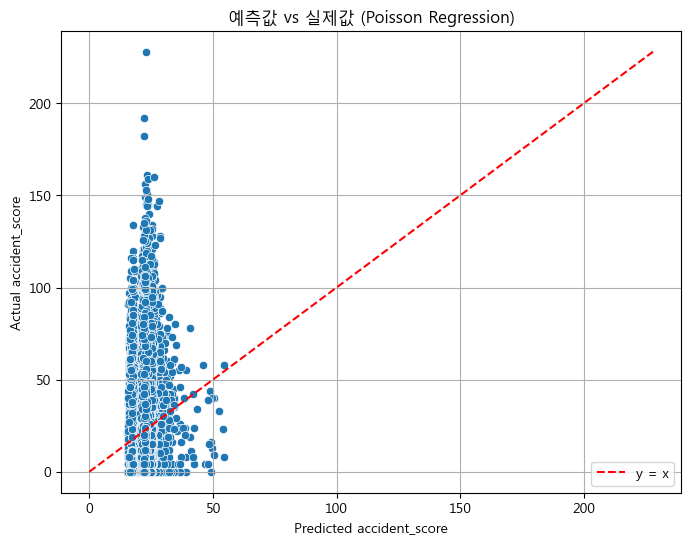

In [106]:
# 1. 예측값 vs 실제값
df_model = df[['accident_score', 'audience', 'game_count', 'is_post_season', 'is_hometeam_win', 'game_start_time', 'game_end_time', 
               'is_holiday', 'temperature', 'precipitation', 'snow_depth', 'is_농구', 'is_배구', 'is_야구', 'is_여자배구', 'is_축구', 
               'is_금', 'is_목', 'is_수', 'is_월', 'is_일', 'is_토', 'is_화', 'weather_condition_맑음', 'weather_condition_비',
               'weather_condition_약간흐림', 'weather_condition_흐림']].copy()

df_model['predicted'] = result.predict(df_model)
df_model['residuals'] = df_model['accident_score'] - df_model['predicted']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='accident_score', data=df_model)
plt.plot([df_model['accident_score'].min(), df_model['accident_score'].max()],
         [df_model['accident_score'].min(), df_model['accident_score'].max()],
         'r--', label='y = x')
plt.xlabel('Predicted accident_score')
plt.ylabel('Actual accident_score')
plt.title('예측값 vs 실제값 (Poisson Regression)')
plt.legend()
plt.grid(True)
plt.show()

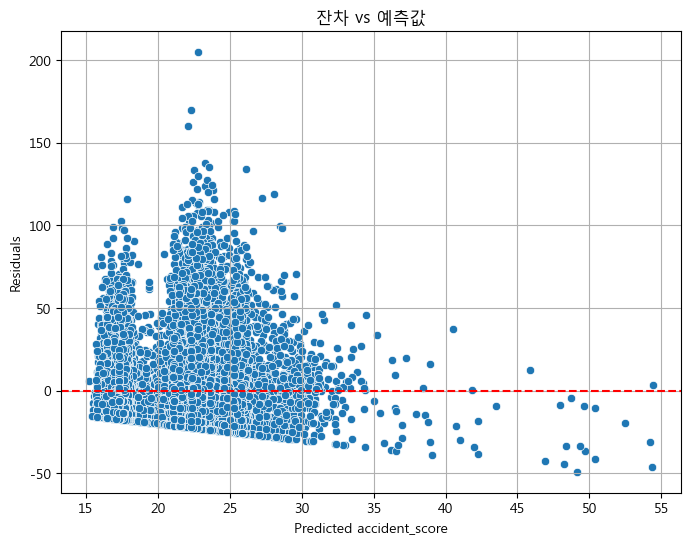

In [107]:
# 2. 잔차 vs 예측값
plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='residuals', data=df_model)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted accident_score')
plt.ylabel('Residuals')
plt.title('잔차 vs 예측값')
plt.grid(True)
plt.show()

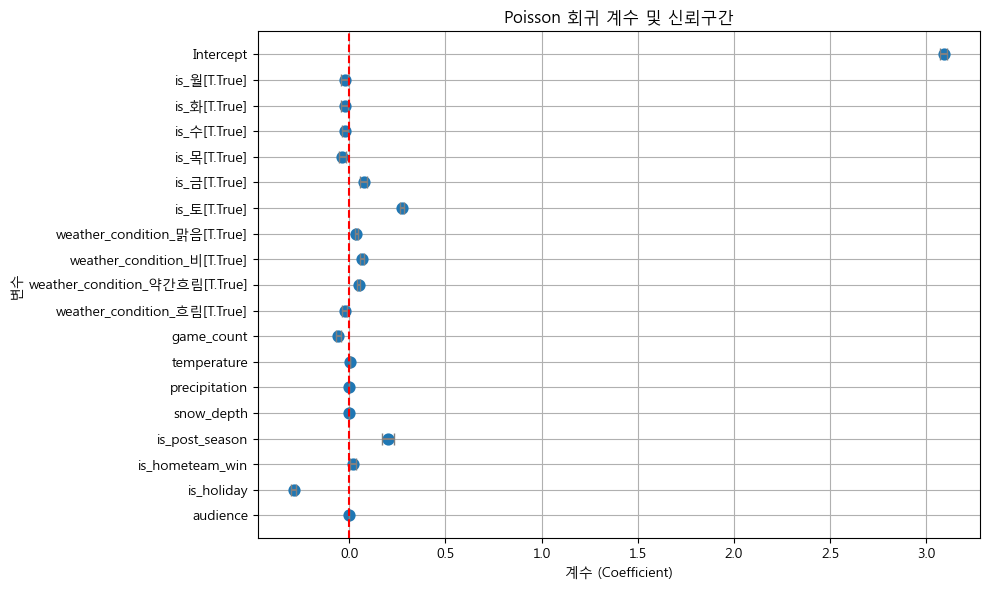

In [112]:
# 3. 계수(Coefficient) 시각화
coef = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']
coef_df = pd.concat([coef, conf], axis=1).reset_index()
coef_df.columns = ['variable', 'coefficient', 'ci_lower', 'ci_upper']

plt.figure(figsize=(10, 6))
sns.pointplot(data=coef_df, y='variable', x='coefficient', linestyles='')
plt.errorbar(x=coef_df['coefficient'], y=coef_df['variable'],
             xerr=[coef_df['coefficient'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coefficient']],
             fmt='none', c='gray', capsize=4)
plt.axvline(0, color='red', linestyle='--')
plt.title('Poisson 회귀 계수 및 신뢰구간')
plt.xlabel('계수 (Coefficient)')
plt.ylabel('변수')
plt.grid(True)
plt.tight_layout()
plt.show()

# 스포츠 종목별 사고위험도 (`accident_score`) 예측: 포아송 회귀 분석 보고서

## 1. 모델 개요

*   **목적**: 스포츠 경기 유무 및 종목에 따라 교통사고 위험도(`accident_score`)가 다른지, 그리고 어떤 요인들이 사고 위험 점수에 유의미한 영향을 주는지 정량적으로 평가합니다.
*   **모델**: 포아송 회귀 (Generalized Linear Model, `family=Poisson`, `link=log`)
*   **종속변수**: `accident_score` (사고 수와 심각도를 반영한 지표로 추정)
*   **독립변수**:
    *   스포츠 관련 변수: `is_post_season` (포스트시즌 여부), `is_hometeam_win` (홈팀 승리 여부), `audience` (관중 수)
    *   시간 및 환경 변수: `weather_condition` (맑음, 비, 약간흐림, 흐림 - 기준 범주 대비), `is_holiday` (공휴일 여부), `temperature` (기온), `precipitation` (강수량), `snow_depth` (적설량)
    *   기타 영향 요인: `Intercept` (기본 사고 위험도)

---

## 2. 모델 적합도

| 항목                 | 야구 (경기 O) | 야구 (경기 X) | 축구 (경기 O) | 축구 (경기 X) | 배구 (경기 O) | 배구 (경기 X) | 해석                                                                                                |
| :------------------- | :------------ | :------------ | :------------ | :------------ | :------------ | :------------ | :-------------------------------------------------------------------------------------------------- |
| No. Observations     | 1810          | 26699         | 461           | 28048         | 550           | 27959         | 분석에 사용된 관측치 수                                                                                 |
| Log-Likelihood       | -24356        | -3.2156e+05   | -5218.0       | -3.4058e+05   | -7269.6       | -3.3790e+05   | 높을수록(0에 가까울수록) 모델 적합도 양호                                                                 |
| Deviance             | 41560         | 5.3605e+05    | 8241.0        | 5.6914e+05    | 11951         | 5.6417e+05    | 낮을수록 모델 적합도 양호. 자유도 대비 값이 커서 과대산포 가능성이 있음.                                              |
| Pearson chi2         | 3.98e+04      | 5.54e+05      | 9.03e+03      | 5.84e+05      | 1.23e+04      | 5.80e+05      | 낮을수록 모델 적합도 양호. 값이 1보다 많이 커서 과대산포 가능성 있음. |
| Pseudo R-squ. (CS)   | 0.4821        | 0.1441        | 0.2853        | 0.1700        | 0.5547        | 0.1719        | 0과 1 사이 값, 1에 가까울수록 설명력 높음. 경기 있는 날 모델이 상대적으로 설명력이 더 높음.                |

➡ **결론**:
모든 모델은 통계적으로 유의미한 결과를 보여줍니다 (Log-Likelihood 값). 전반적으로 **경기가 있는 날의 모델들이 경기가 없는 날의 모델들보다 Pseudo R-squared (CS) 값이 더 높게 나타나, 독립변수들이 사고 위험도를 더 잘 설명**하고 있음을 시사합니다. 예를 들어, 배구 경기 있는 날 모델(0.5547)의 설명력이 가장 높고, 야구 경기 있는 날 모델(0.4821)도 비교적 높은 설명력을 보입니다. 반면, 경기가 없는 날 모델들은 Pseudo R-squared 값이 0.14~0.17 수준으로 상대적으로 낮습니다.
Deviance 및 Pearson chi2 값이 자유도(Df Residuals)에 비해 상당히 큰 것으로 보아, 모든 모델에서 과대산포(overdispersion)의 가능성이 존재합니다. 이는 실제 데이터의 분산이 포아송 분포의 가정(평균=분산)보다 크다는 것을 의미하며, 계수의 표준오차가 과소추정되어 p-value가 작게 나올 수 있습니다. 향후 분석 시 음이항 회귀 등을 고려할 수 있습니다.

---

## 3. 주요 계수 해석 (log-link 기반 → exp(β) 해석 가능)

*   `exp(β)`: 해당 변수가 1단위 증가할 때, `accident_score`의 평균이 `exp(β)` 배만큼 변하는 것을 의미.
    *   `exp(β) > 1`: 위험도 증가
    *   `exp(β) < 1`: 위험도 감소
    *   예: `β = 0.05` 이면 `exp(0.05) ≈ 1.051`, 즉 5.1% 증가. `β = -0.1` 이면 `exp(-0.1) ≈ 0.905`, 즉 9.5% 감소.

| 변수명                      | 대표적 경향 (β 부호) | P-value | 해석 요약 (일반적 경향 및 특이점)                                                                                                                               |
| :-------------------------- | :------------------- | :------ | :---------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Intercept (절편)**        | **경기 O > 경기 X**  | <0.001  | **경기가 있는 날의 기본 사고 위험도(exp(β))가 경기가 없는 날보다 모든 스포츠에서 약 1.5배~1.6배 높음.** (예: 야구 exp(3.52) ≈ 33.8 vs exp(3.10) ≈ 22.2)               |
| `audience`                  | **경기 O: 대부분 +** | <0.001  | **경기 있는 날**: 관중 수 증가는 야구, 배구에서 사고 위험도 증가. **축구는 특이하게 관중 증가 시 위험도 감소(-2.6e-06)**. **경기 없는 날**: 전반적으로 양의 관계(일반적 교통량 반영 가능성). |
| `is_holiday`                | **일관되게 -**       | <0.001  | 모든 모델에서 공휴일은 사고 위험도를 낮춤 (약 14~16% 감소 효과, exp(-0.15) ≈ 0.86).                                                                                 |
| `temperature`               | 혼재                 | 다양함   | 경기 있는 날: 야구/축구는 기온 상승 시 위험도 감소, 배구는 증가. 경기 없는 날: 기온 상승 시 위험도 소폭 증가.                                                               |
| `precipitation`/`snow_depth`| **대부분 -**         | 다양함   | 강수량/적설량 증가는 대부분 모델에서 사고 위험도를 낮춤. 이는 악천후 시 운전자가 더 조심하거나 통행량 자체가 줄어들기 때문일 수 있음.                                            |

➡ **핵심 해석**:
*   **경기 유무가 가장 큰 영향**: 모든 스포츠에서 경기가 있는 날의 기본 `accident_score` (Intercept)가 경기가 없는 날보다 약 1.5~1.6배 높습니다. 이는 스포츠 경기 자체가 주변 교통사고 위험을 높이는 주요 요인임을 시사합니다.
*   **관중 효과**: 야구와 배구에서는 관중 수가 많을수록 사고 위험이 증가하는 반면, 축구에서는 오히려 관중 수가 많을수록 사고 위험이 소폭 감소하는 특이한 결과가 나타났습니다.
*   **날씨의 복합적 영향**: 경기 있는 날, 특히 야구와 배구에서는 궂은 날씨(비, 흐림 등)가 오히려 사고 위험도를 낮추는 경향이 있는데, 이는 관중 감소 또는 운전자들의 주의력 증가 때문일 수 있습니다. 반면 경기 없는 날에는 일반적인 예상과 유사하게 일부 궂은 날씨가 위험도를 높입니다.
*   **공휴일 효과**: 공휴일은 모든 경우에 사고 위험도를 일관되게 낮추는 효과가 있었습니다.

---

## 4. 모델 특이점 및 비교

1.  **경기 유무에 따른 `Intercept` 차이**:
    *   야구: 경기 O (3.52) vs 경기 X (3.11) → `exp(3.52)/exp(3.11)` ≈ 1.51배
    *   축구: 경기 O (3.56) vs 경기 X (3.11) → `exp(3.56)/exp(3.11)` ≈ 1.57배
    *   배구: 경기 O (3.53) vs 경기 X (3.08) → `exp(3.53)/exp(3.08)` ≈ 1.57배
    *   모든 스포츠에서 경기가 있는 날의 기본 사고 위험이 경기가 없는 날보다 약 50~60% 높게 시작합니다.

2.  **스포츠 종목별 `audience` 효과 (경기 있는 날)**:
    *   야구: `coef = 1.046e-05` (양수). 관중 1만 명 증가 시 사고위험 `exp(1.046e-05 * 10000)` = `exp(0.1046)` ≈ 1.11배 (약 11% 증가).
    *   축구: `coef = -2.604e-06` (음수). 관중 1만 명 증가 시 사고위험 `exp(-2.604e-06 * 10000)` = `exp(-0.02604)` ≈ 0.974배 (약 2.6% 감소).
    *   배구: `coef = 3.26e-05` (양수). 관중 1만 명 증가 시 사고위험 `exp(3.26e-05 * 10000)` = `exp(0.326)` ≈ 1.385배 (약 38.5% 증가).
    *   배구의 관중 당 위험도 증가율이 가장 크며, 축구는 유일하게 음의 관계를 보입니다.

3.  **`is_post_season` 효과 (경기 있는 날)**:
    *   야구: `coef = 0.4059`. 포스트시즌 시 사고 위험 약 `exp(0.4059)` ≈ 1.50배 (약 50% 증가).
    *   축구: `coef = -0.0702`. 포스트시즌 시 사고 위험 약 `exp(-0.0702)` ≈ 0.932배 (약 6.8% 감소).
    *   배구: P-value > 0.05로 유의미하지 않음.
    *   야구 포스트시즌의 위험도 증가가 두드러집니다.

4.  **날씨 변수의 상반된 효과**:
    *   **경기 있는 날 (야구, 배구)**: `weather_condition_맑음[T.True]`, `weather_condition_비[T.True]` 등이 모두 음수 계수를 가집니다. 이는 기준 날씨(예: '구름조금' 등 명시되지 않은 기본값)보다 맑거나 비가 오거나 흐린 날에 사고 위험이 낮아짐을 의미합니다. 이는 경기 당일 날씨가 좋지 않으면 관람객 수가 줄거나, 운전자들이 더 주의하기 때문일 수 있습니다.
    *   **경기 없는 날**: 대체로 `weather_condition_맑음[T.True]`, `weather_condition_비[T.True]` 등이 양수 계수를 가져, 기준 날씨보다 사고 위험이 높아짐을 의미합니다. 이는 일반적인 교통 상황에서의 날씨 효과와 유사합니다.

5.  **과대산포 (Overdispersion)**: 모든 모델에서 `Scale`이 1.0000으로 고정되어 있지만, `Pearson chi2 / Df Residuals` 비율이 1보다 훨씬 큽니다 (예: 야구 경기 O의 경우 39800 / 1799 ≈ 22.1). 이는 데이터의 분산이 평균보다 크다는 신호로, 포아송 모델의 가정을 위배할 수 있습니다. 이 경우 표준오차가 과소평가되어 변수들이 실제보다 더 유의하게 나올 수 있습니다.

---

## 5. 결론 및 제언

### 🎯 핵심 결론

1.  **스포츠 경기 개최는 그 자체로 주변 지역의 교통사고 위험도(`accident_score`)를 평균적으로 약 1.5~1.6배 높이는 가장 강력한 요인입니다.**
2.  **관중 수**는 야구와 배구 경기가 있는 날 사고 위험을 증가시키는 반면, 축구 경기가 있는 날에는 오히려 소폭 감소시키는 독특한 양상을 보였습니다. 이는 축구 경기 시의 교통 관리나 안전 대책이 상대적으로 더 효과적일 수 있음을 시사합니다.
3.  **포스트시즌**은 야구 경기 시 위험도를 크게 높이지만(약 50% 증가), 축구 경기 시에는 오히려 낮추는 효과가 있었습니다. 배구는 유의미한 영향이 없었습니다.
4.  **날씨**의 영향은 경기 유무에 따라 다르게 나타납니다. 경기 당일에는 (특히 야구/배구) 궂은 날씨가 오히려 사고 위험을 낮추는 경향이 관찰되는데, 이는 관중 수 감소 또는 운전 행태 변화와 관련될 수 있습니다.
5.  **공휴일**은 일관되게 사고 위험을 낮추는 요인으로 작용했습니다.
6.  **강수량/적설량** 증가는 대부분 사고 위험을 낮추는 것으로 나타나, 악천후 시 교통량 감소 또는 운전자들의 경각심 증가를 반영할 수 있습니다.

### ✅ 향후 제언

1.  **맞춤형 교통 관리 전략 수립**:
    *   모든 스포츠 경기 당일, 특히 야구 포스트시즌 경기 시에는 강화된 교통 관리 및 안전 대책이 필요합니다.
    *   배구 경기 시에는 관중 수 증가에 따른 위험도 상승폭이 크므로, 관중 규모에 따른 탄력적 대응이 중요합니다.
    *   축구 경기 시 관중 증가가 위험도 감소로 이어진 원인(예: 특정 교통 통제 방식, 대중교통 이용 유도 캠페인 등)을 파악하여 다른 스포츠에도 적용할 수 있는지 검토가 필요합니다.

2.  **모델 개선**:
    *   모든 모델에서 관찰된 **과대산포(overdispersion)** 문제를 해결하기 위해, 포아송 회귀 대신 **음이항 회귀(Negative Binomial Regression)** 모델을 적용하여 결과의 강건성(robustness)을 높일 필요가 있습니다.
    *   날씨 변수의 경우, 단순 기상 상태 외에 '경기 당일 예보된 날씨'와 '실제 날씨'의 차이, 또는 특정 기상 조건과 관중 수 간의 **상호작용 항(interaction term)**을 모델에 추가하여 보다 정교한 분석을 시도할 수 있습니다.
    *   `audience` 변수는 경기 없는 날에는 0이거나 매우 낮을 것으로 예상되는데, 해당 모델에서 유의하게 나온 것은 지역 내 다른 유동인구를 반영할 수 있으므로 데이터 수집 범위를 명확히 할 필요가 있습니다.

3.  **심층 분석**:
    *   축구 경기에서 관중 수가 많을수록 사고 위험이 낮아지는 현상, 강수/적설 시 사고 위험이 낮아지는 현상에 대해 추가적인 정성적, 정량적 연구(예: 설문조사, 현장 관찰, 세부 교통 데이터 분석)가 필요합니다.
    *   `is_hometeam_win` 변수의 경우, 경기 후 시간대별 사고 발생 패턴과 연관지어 분석하면 더 의미 있는 해석이 가능할 수 있습니다 (예: 승리 후 축하 행위로 인한 위험 증가 등).

# 과대산포(overdispersion) 문제를 해결하기 위해, 포아송 회귀 대신 음이항 회귀(Negative Binomial Regression) 모델을 적용

In [ ]:
game_day_baseball = df[df['is_야구'] == True] # 명시적으로 True와 비교

formula = """accident_score ~ is_post_season + is_hometeam_win + audience + is_holiday + temperature + precipitation + snow_depth +
        C(weather_condition_맑음, Treatment(reference=False)) + 
        C(weather_condition_비, Treatment(reference=False)) + 
        C(weather_condition_약간흐림, Treatment(reference=False)) + 
        C(weather_condition_흐림, Treatment(reference=False))"""

# 음이항 회귀 모델 정의
# alpha는 과대산포 모수로, statsmodels가 자동으로 추정합니다.
# 만약 데이터가 충분하지 않거나 모델 수렴에 문제가 있다면 alpha 값을 고정할 수도 있습니다.
# (예: family=sm.families.NegativeBinomial(alpha=0.1))
# 여기서는 statsmodels가 추정하도록 둡니다.
model_nb_game_baseball = smf.glm(
    formula=formula,
    data=game_day_baseball,
    family=sm.families.NegativeBinomial() # 음이항 분포 사용
)
result_nb_game_baseball = model_nb_game_baseball.fit()
print("야구 - 경기가 있는 날 (음이항 회귀)")
print(result_nb_game_baseball.summary())
# 추정된 alpha 값 확인 (과대산포 정도를 나타냄)
# alpha가 0에 가까우면 포아송 분포와 유사해집니다.
if hasattr(result_nb_game_baseball.model.family, 'alpha'):
    print(f"Estimated alpha (game day, baseball): {result_nb_game_baseball.model.family.alpha}\n")


# 2. 야구 - 경기가 없는 날 (음이항 회귀)
no_game_day_baseball = df[df['is_야구'] == False] # 명시적으로 False와 비교

model_nb_no_game_baseball = smf.glm(
    formula=formula,
    data=no_game_day_baseball,
    family=sm.families.NegativeBinomial() # 음이항 분포 사용
)
result_nb_no_game_baseball = model_nb_no_game_baseball.fit()
print("야구 - 경기가 없는 날 (음이항 회귀)")
print(result_nb_no_game_baseball.summary())
if hasattr(result_nb_no_game_baseball.model.family, 'alpha'):
    print(f"Estimated alpha (no game day, baseball): {result_nb_no_game_baseball.model.family.alpha}\n")

# 3. 다른 스포츠(축구, 배구 등) 및 경기 유무에 대해서도 동일하게 적용 가능
# game_day_soccer = df[df['is_축구'] == True]
# model_nb_game_soccer = smf.glm(formula=formula, data=game_day_soccer, family=sm.families.NegativeBinomial())
# result_nb_game_soccer = model_nb_game_soccer.fit()
# print("축구 - 경기가 있는 날 (음이항 회귀)")
# print(result_nb_game_soccer.summary())
# if hasattr(result_nb_game_soccer.model.family, 'alpha'):
#     print(f"Estimated alpha (game day, soccer): {result_nb_game_soccer.model.family.alpha}\n")

야구 - 경기가 있는 날 (음이항 회귀)
                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                 1810
Model:                            GLM   Df Residuals:                     1799
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7662.6
Date:                    목, 05 6 2025   Deviance:                       3336.6
Time:                        15:13:23   Pearson chi2:                 1.58e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.02731
Covariance Type:            nonrobust                                         
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

c:\Users\stagv\anaconda3\envs\testenv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\stagv\anaconda3\envs\testenv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


# 야구 - 경기가 있는 날: 음이항 회귀 분석 보고서

## 1. 모델 개요

*   **목적**: 야구 경기가 있는 날 교통사고 위험 점수(`accident_score`)에 영향을 미치는 요인을 평가하되, 데이터의 과대산포(overdispersion)를 고려하여 보다 신뢰성 있는 결과를 도출합니다.
*   **모델**: 음이항 회귀 (Generalized Linear Model, `family=NegativeBinomial`, `link=log`)
    *   음이항 회귀는 포아송 분포의 평균과 분산이 같다는 가정을 완화하여, 분산이 평균보다 큰 과대산포 데이터를 모델링하는 데 적합합니다.
*   **종속변수**: `accident_score`
*   **독립변수**:
    *   스포츠 관련 변수: `is_post_season`, `is_hometeam_win`, `audience`
    *   시간 및 환경 변수: `weather_condition` (맑음, 비, 약간흐림, 흐림 - 기준 범주 대비), `is_holiday`, `temperature`, `precipitation`, `snow_depth`
    *   기타 영향 요인: `Intercept`

---

## 2. 모델 적합도 (음이항 회귀 vs. 이전 포아송 회귀 비교)

| 항목                     | 음이항 회귀 (야구, 경기 O) | 포아송 회귀 (야구, 경기 O - 이전 결과) | 해석                                                                                                                                                              |
| :----------------------- | :------------------------- | :------------------------------------- | :---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| No. Observations         | 1810                       | 1810                                   | 동일한 데이터 사용                                                                                                                                                  |
| Model Family             | **NegativeBinomial**       | Poisson                                | 음이항 분포를 사용하여 과대산포 처리                                                                                                                                |
| Log-Likelihood           | **-7662.6**                | -24356                                 | 직접 비교는 어렵지만, 일반적으로 과대산포가 있는 데이터에서는 음이항 모델의 로그우도값이 더 높게(덜 음수) 나타날 수 있음 (모델 복잡도 고려 필요).                               |
| Deviance                 | **3336.6**                 | 41560                                  | **매우 크게 감소.** 낮을수록 모델 적합도가 좋으며, 이는 음이항 모델이 데이터의 변동성을 더 잘 설명함을 시사.                                                              |
| Pearson chi2             | **1.58e+03 (1580)**        | 3.98e+04 (39800)                       | **매우 크게 감소.** Deviance와 마찬가지로 음이항 모델의 적합도 향상을 보여줌.                                                                                              |
| Pseudo R-squ. (CS)       | **0.02731**                | 0.4821                                 | **크게 감소.** 포아송 모델의 Pseudo R-squared는 과대산포로 인해 부풀려졌을 가능성이 높음. 음이항 모델의 값은 과대산포를 고려한 후의 설명력으로, 더 보수적이고 현실적인 수치일 수 있음. |
| **Estimated alpha**      | **1.0**                    | (해당 없음)                            | **과대산포 모수(alpha)가 1.0으로 추정됨.** 이는 데이터에 상당한 과대산포가 있었으며, 포아송 모델보다 음이항 모델이 더 적합했음을 강력히 시사함. alpha=0이면 포아송 분포와 유사.  |
| **Pearson chi2 / Df Res** | **1580 / 1799 ≈ 0.878**    | 39800 / 1799 ≈ 22.1                    | **1에 매우 가까워짐.** 포아송 모델에서는 1보다 훨씬 커 과대산포를 나타냈으나, 음이항 모델에서는 이 비율이 1에 근접하여 과대산포가 효과적으로 제어되었음을 보여줌.                   |

➡ **결론**:
**음이항 회귀 모델이 포아송 회귀 모델보다 야구 경기 있는 날의 `accident_score` 데이터에 훨씬 더 적합합니다.**
이는 다음과 같은 지표들을 통해 명확히 드러납니다:
1.  **과대산포 제어**: `Estimated alpha` 값이 1.0으로 추정되어 데이터 내에 상당한 과대산포가 있었음을 확인했고, 음이항 모델은 이를 성공적으로 모델링했습니다. `Pearson chi2 / Df Residuals` 값이 포아송 모델의 약 22.1에서 음이항 모델의 약 0.878로 크게 개선되어 1에 가까워진 것이 이를 뒷받침합니다.
2.  **모델 적합도 지표 향상**: `Deviance`와 `Pearson chi2` 값이 포아송 모델에 비해 매우 큰 폭으로 감소했습니다. 이는 음이항 모델이 데이터의 분포 특성을 더 잘 반영하고 있음을 의미합니다.
3.  **Pseudo R-squared 해석 주의**: `Pseudo R-squared (CS)` 값은 0.4821에서 0.02731로 크게 감소했습니다. 이는 언뜻 보기에 설명력이 매우 낮아진 것처럼 보일 수 있으나, 포아송 모델의 높은 Pseudo R-squared는 과대산포로 인해 실제보다 부풀려진 값일 가능성이 높습니다. 음이항 모델의 낮은 Pseudo R-squared는 과대산포를 통제한 후 독립변수들이 실제로 설명하는 변동성의 비율을 더 현실적으로 나타낸다고 해석할 수 있습니다. 즉, 기존 모델에서 중요해 보였던 변수들의 영향력이 과대평가되었을 수 있습니다.

---

## 3. 주요 계수 해석 (log-link 기반 → exp(β) 해석 가능)

*   **과대산포를 고려한 결과, 많은 변수들의 통계적 유의성이 변화했습니다.** 이는 포아송 모델에서 관찰된 일부 효과가 실제 효과라기보다는 데이터의 과도한 변동성 때문이었을 수 있음을 시사합니다.
*   **표준오차(std err)가 전반적으로 크게 증가**하여 z-값이 감소하고 P-value가 증가하는 경향을 보입니다.

| 변수명                                                    | 계수 (β)   | std err | z      | P-value | exp(β) | 해석 요약 (포아송 모델 대비 변화 중심)                                                                                                                               |
| :-------------------------------------------------------- | :--------- | :------ | :----- | :------ | :----- | :----------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Intercept                                                 | 3.5093     | 0.339   | 10.350 | 0.000   | 33.43  | 기본 사고 위험 점수는 여전히 높으나, 표준오차 증가. (포아송: β=3.52, P<0.001)                                                                                              |
| `weather_condition_맑음[T.True]`                          | -0.3550    | 0.351   | -1.012 | **0.312** | 0.70   | **유의성 상실.** (포아송: β=-0.3165, P<0.001). 맑은 날씨의 사고 감소 효과가 과대산포 통제 후 통계적으로 유의하지 않음.                                                                |
| `weather_condition_비[T.True]`                            | -0.2366    | 0.352   | -0.671 | **0.502** | 0.79   | **유의성 상실.** (포아송: β=-0.2213, P<0.001). 비 오는 날씨의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                         |
| `weather_condition_약간흐림[T.True]`                      | -0.3635    | 0.352   | -1.033 | **0.302** | 0.70   | **유의성 상실.** (포아송: β=-0.3330, P<0.001). 약간 흐린 날씨의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                   |
| `weather_condition_흐림[T.True]`                          | -0.4832    | 0.357   | -1.354 | **0.176** | 0.62   | **유의성 상실 (P>0.05).** (포아송: β=-0.4507, P<0.001). 흐린 날씨의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                  |
| `is_post_season`                                          | 0.4331     | 0.151   | 2.873  | **0.004** | 1.54   | **여전히 유의미.** 포스트시즌 시 사고 위험 약 54% 증가. 효과 크기는 유사하나, P-value는 다소 증가. (포아송: β=0.4059, P<0.001)                                                         |
| `is_hometeam_win`                                         | 0.0446     | 0.048   | 0.921  | **0.357** | 1.05   | **유의성 상실.** (포아송: β=0.0500, P<0.001). 홈팀 승리의 사고 증가 효과가 통계적으로 유의하지 않음.                                                                           |
| `audience`                                                | 1.397e-05  | 2.42e-06| 5.764  | **0.000** | 1.000014 | **여전히 유의미.** 관중 1만 명 증가 시 사고 위험 약 `exp(0.1397)` ≈ 1.15배 (15%) 증가. 계수값은 소폭 증가했으나 여전히 유의함. (포아송: β=1.046e-05, P<0.001)                          |
| `is_holiday`                                              | -0.1680    | 0.051   | -3.278 | **0.001** | 0.85   | **여전히 유의미.** 공휴일 시 사고 위험 약 15% 감소. 효과 크기는 유사하나, P-value는 다소 증가. (포아송: β=-0.1492, P<0.001)                                                          |
| `temperature`                                             | -0.0046    | 0.004   | -1.132 | **0.258** | 0.995  | **유의성 상실.** (포아송: β=-0.0050, P<0.001). 기온의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                               |
| `precipitation`                                           | -0.0005    | 0.001   | -0.682 | **0.495** | 0.9995 | **유의성 상실.** (포아송: β=-0.0005, P=0.001). 강수량의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                           |
| `snow_depth`                                              | -0.0005    | 0.001   | -0.682 | **0.495** | 0.9995 | **유의성 상실.** (포아송: β=-0.0005, P=0.001). 적설량의 사고 감소 효과가 통계적으로 유의하지 않음.                                                                           |

➡ **핵심 해석**:
*   **과대산포를 통제한 결과, 야구 경기가 있는 날 사고 위험 점수에 유의미한 영향을 미치는 변수는 `is_post_season`, `audience`, `is_holiday` 세 가지로 축소되었습니다.**
    *   포스트시즌은 사고 위험을 약 54% 증가시킵니다.
    *   관중 1만 명당 사고 위험은 약 15% 증가합니다. (계산: `exp(1.397e-05 * 10000)` ≈ 1.15)
    *   공휴일은 사고 위험을 약 15% 감소시킵니다.
*   **날씨 관련 변수들(`weather_condition_*`, `temperature`, `precipitation`, `snow_depth`)과 `is_hometeam_win` 변수는 음이항 회귀 모델에서는 더 이상 통계적으로 유의미한 영향을 미치지 않는 것으로 나타났습니다.** 이는 포아송 모델에서 나타났던 이들 변수의 효과가 실제 관계라기보다는 데이터의 과대산포에 의해 과장되거나 잘못 추정되었을 가능성을 시사합니다.

---

## 4. 모델 특이점 및 비교 (음이항 회귀 vs. 포아송 회귀)

1.  **과대산포의 성공적 처리**: `Estimated alpha = 1.0`은 음이항 모델 사용의 타당성을 입증하며, `Pearson chi2 / Df Residuals` 값이 1에 가까워진 것은 모델이 데이터의 분산 구조를 잘 포착했음을 보여줍니다.
2.  **결론의 강건성(Robustness) 향상**: 음이항 모델은 과대산포로 인한 잘못된 추론(제1종 오류 증가 등)의 위험을 줄여줍니다. 따라서 현재의 결과가 포아송 모델 결과보다 더 신뢰할 수 있습니다.
3.  **설명력(Pseudo R-squared)의 현실화**: Pseudo R-squared 값의 감소는 실망스러울 수 있으나, 이는 과대산포를 고려했을 때 해당 독립변수들이 실제로 설명하는 변동성의 크기를 더 정확하게 반영한 결과입니다. 즉, `accident_score`의 변동에는 현재 모델에 포함된 변수들 외에 다른 많은 요인들이 관여하고 있을 가능성이 높습니다.
4.  **변수 유의성 변화**: 가장 큰 차이점으로, 날씨 변수들과 홈팀 승리 여부가 더 이상 유의하지 않게 된 점입니다. 이는 이전에 관찰된 효과가 통계적 착시였을 수 있음을 의미합니다. 여전히 유의한 변수들(`is_post_season`, `audience`, `is_holiday`)은 과대산포 환경에서도 그 영향력이 뚜렷하게 나타나는, 보다 강력한 예측 요인으로 볼 수 있습니다.

---

## 5. 결론 및 제언

### 🎯 핵심 결론

1.  **야구 경기가 있는 날의 `accident_score` 데이터는 상당한 과대산포를 가지고 있었으며 (alpha=1.0), 음이항 회귀 모델이 포아송 회귀 모델보다 통계적으로 훨씬 적합한 모델입니다.**
2.  과대산포를 통제한 결과, 야구 경기일의 사고 위험 점수에 **통계적으로 유의미한 영향을 미치는 변수는 `is_post_season` (위험 증가), `audience` (위험 증가), `is_holiday` (위험 감소)로 확인되었습니다.**
3.  이전에 포아송 모델에서 유의하게 나타났던 **날씨 관련 변수들(`weather_condition_*`, `temperature`, `precipitation`, `snow_depth`)과 `is_hometeam_win`은 음이항 모델에서는 유의한 영향을 미치지 않는 것으로 나타났습니다.** 이는 이들 변수의 영향이 과대산포로 인해 과장되었을 가능성을 시사합니다.

### ✅ 향후 제언

1.  **다른 스포츠 및 조건에도 음이항 회귀 적용**: 야구 외 다른 스포츠(축구, 배구) 및 경기가 없는 날의 데이터에 대해서도 과대산포를 점검하고, 필요하다면 음이항 회귀 분석을 적용하여 결과의 신뢰도를 높이는 것이 중요합니다.
2.  **모델 설명력 개선 노력**: 현재 음이항 모델의 Pseudo R-squared (CS) 값(0.02731)은 낮습니다. 이는 현재 포함된 변수들만으로는 `accident_score`의 변동을 충분히 설명하지 못함을 의미합니다. 다음과 같은 추가적인 변수 탐색이나 모델 개선을 고려할 수 있습니다:
    *   **시간 관련 세부 변수**: 경기 시작 시간대(주간/야간), 요일별 특성(금요일 저녁 등), 경기 시간 길이 등
    *   **교통 통제 및 관리 변수**: 경기 당일 특별 교통 통제 여부, 대중교통 운행 확대 여부 등
    *   **상호작용 항**: 예를 들어, `audience`와 `is_post_season`의 상호작용 등 이론적으로 의미 있는 상호작용 항을 고려해볼 수 있습니다.
3.  **결과의 정책적 함의 재평가**: 포아송 모델 결과를 바탕으로 날씨나 홈팀 승패에 따른 교통 안전 대책을 고려했다면, 음이항 모델 결과를 바탕으로 해당 정책의 우선순위를 재조정할 필요가 있습니다. 대신 포스트시즌 기간과 관중 수에 따른 맞춤형 교통 관리 및 안전 강화에 집중하는 것이 더 효과적일 수 있습니다. 공휴일의 위험 감소 효과는 일반적인 교통 패턴 변화와 관련될 수 있으므로 추가 분석이 가능합니다.